## Data Preparation Pipeline (Coswara)

This notebook prepares the Coswara dataset for training by applying a series of cleaning, filtering, and transformation steps tailored to its structure and metadata.

The dataset and source repository can be found here: https://github.com/iiscleap/Coswara-Data

Note:
- The code is designed to run in Google Colab with helper functions and scripts imported from Google Drive. All helper scripts are stored in the data_preparation folder.
- The output examples shown in this notebook are for illustration only. They use a small sample of files to help you understand what the full pipeline should look like when properly run.
- When running the pipeline on the full dataset, make sure to do the following using the helper functions provided:
    - Download and extract the Coswara .tar.gz.* split files
    - Consolidate only the *_cough-heavy.wav recordings
    - Clean and match metadata for high-quality, labeled samples

Pipeline Summary:

0. Mount Google Drive
1. (Skipped) Data Download and Extraction (Coswara)
2. (Skipped) Prepare Metadata / Labels (Coswara)
3. Convert and Copy Raw Audio
4. Process Audio Files
5. Train-Test Split and Label Alignment
6. Data Integrity Check

### 0. Mount Google Drive

- This step handles mounting Drive and ensuring access scripts and datasets stored in your Drive.
- Accompanying helper file: step1_get_zip.py

In [ ]:
# Mount Google Drive to access files
# This code is intended to be run in Google Colab
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# To run this notebook, you need to cd to the folder where the helper files are located.
# You can do this by running the following command:
%cd /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/py_util/

/content/drive/.shortcut-targets-by-id/1UBr7xHwiaUCT4Y9U0LH_0qJJfCYxNbgT/AML/Dataprep/test_coswara_dataprep_for_github/py_util


In [ ]:
# As backup, to use the helper files, we add its path to the system path
# This is not necessary if you are already in the correct directory.
# You can comment this line out if you are already in the correct directory.
import sys
sys.path.append('/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/py_util')

In [ ]:
# Importing the function to check if the drive is mounted, and to mount it if not
from step1_get_zip import mount_drive
mount_drive()

Google Drive already mounted.


Expected Output:
- Google Drive mounted
- Able to access helper files

### 1. (Skipped) Data Download and Extraction (Coswara)

- This step handles downloading and extracting the Coswara dataset for first-time users or full reproducibility.
- Source: Coswara dataset GitHub repository: https://github.com/iiscleap/Coswara-Data
    - Download the file: coswara_data.tar.gz.* split archives (e.g., .tar.gz.aa, .tar.gz.ab, etc.)
    - Each date-based folder (e.g., 20210507/) contains raw audio samples from multiple participants
- Contents of the repository:
    - Multiple folders named by collection date (e.g., 20200413, 20210630, etc.)
    - Each folder contains recordings from participants (9 audio samples per participant)
    - Files include .wav audio recordings and .json metadata
- Metadata files:
    - combined_data.csv: central metadata file containing participant-level health status and demographics
    - csv_labels_legend.json: column descriptions for metadata
    - annotations/: contains audio quality ratings labeled as:
        - 2 = excellent
        - 1 = moderate
        - 0 = bad
- What is required:
    - Only the audio files ending in _cough-heavy.wav are used for this project
    - Metadata in combined_data.csv and quality annotations are used for filtering and labeling
    - Other audio types and JSONs can be ignored
- How to extract:
    - Use the helper function extract_coswara_archives() from the script step1_get_zip.py to extract .tar.gz.* split archives into a common folder (e.g., Extracted_data/)
    - Then run consolidate_coswara_heavy_cough_files() to:
        - Find all files ending in _cough-heavy.wav
        - Remove _cough-heavy from filenames
        - Copy to a clean, flat folder (e.g., Extracted_data_heavy/)
- Accompanying helper file: step1_get_zip.py
- Note: This notebook skips the raw extraction step. To reproduce the dataset from scratch, use the helper script manually in Colab or locally.

In [ ]:
# Importing the function to unzip the downloaded ZIP file
import os

# Define the directory where the ZIP file is located
# and the directory where you want to extract the contents
# There are two directories: the original and the heavy one
# The original directory contains the original files, while the heavy directory contains the files after preprocessing
# The original directory is used for the first run, and the heavy directory is used for the second run
coswara_data_dir = "/content/drive/MyDrive/AML/Data/dataset3_coswara"  
extracted_data_dir = os.path.join(coswara_data_dir, "extracted_coswara_data")  
extracted_data_heavy_dir = os.path.join(coswara_data_dir, "extracted_coswara_data_heavy_cough")  

In [ ]:
# Importing the function to extract the ZIP file
from step1_get_zip import mount_drive, extract_coswara_archives, consolidate_coswara_heavy_cough_files

# Run the function to extract the ZIP file
# The function will extract the files in the specified directory
# and create a new directory for the extracted files
# The extracted files will be in the same directory as the ZIP file
extract_coswara_archives(coswara_data_dir)

# Run the function to consolidate the heavy cough files
# Because the extracted_data_dir will have nine subdirectories, and we only want to extract the heavy cough files
consolidate_coswara_heavy_cough_files(extracted_data_dir, extracted_data_heavy_dir)

Expected Output:
- A directory named Extracted_data/ is created in your working environment
    - This contains the full decompressed content from all .tar.gz.* Coswara archives
- A directory named Extracted_data_heavy/ is created:
    - Contains only cough-heavy .wav files, one per participant
    - Files are renamed to UUIDs (e.g., a123b456.wav) for easier matching
    - All files are in a single flat folder (no subdirectories)
- Example before consolidation: Extracted_data/20210816/participant1_cough-heavy.wav
- Example after consolidation: Extracted_data_heavy/participant1.wav
- Outcome:
    - You now have all heavy cough .wav audio files locally available for downstream processing (Step 3 onward)
    - The structure is clean, standardized, and ready for quality filtering, labeling, and training preparation
- Note: This notebook skips the Coswara raw extraction step to save time. To replicate results fully, download and extract the full dataset using the helper functions.

### 2.  (Skipped) Prepare Metadata / Labels (Coswara)

- This step extracts and cleans the Coswara metadata to generate binary health labels aligned with available audio files, preparing the dataset for downstream machine learning.
- Source:
    - combined_data.csv — Main metadata file containing health labels
    - cough-heavy.csv — Contains audio quality ratings for cough-heavy samples
- Label processing pipeline:
    - Filter by quality: Retain only samples with QUALITY ≥ 1 (moderate or excellent)
    - Filter by health label: Map Coswara's covid_status field into binary format:
        - -healthy → 1 (Healthy)
        - positive_mild, positive_moderate, resp_illness_not_identified → 0 (Not Healthy)
- Match and retain only audio files:
    - Only keep samples where a corresponding *_cough-heavy.wav file exists
    - Removes _cough-heavy suffix to standardize filenames
- Accompanying helper file: step2_prepare_metadata.py
- Note: This notebook skips the metadata processing step for brevity. To reproduce the label CSV from raw metadata and quality ratings, run the helper script separately.

In [ ]:
import pandas as pd

# Import helper functions from step2_prepare_metadata.py
from step2_prepare_metadata import (
    load_raw_metadata,
    filter_coswara_high_quality,
    combine_coswara_labels,
    match_coswara_ids_and_labels,
    save_labels_csv
)

In [ ]:
# Load the full metadata CSV file with all ids and columns
metadata_csv_path = "/content/drive/MyDrive/AML/Data/dataset3_coswara/combined_data.csv"

# Load the second metadata CSV file with only the ids and the quality rating of 0-2
# The aim is to keep quality 1 and 2, and then match it with the first metadata CSV file
quality_csv_path = "/content/drive/MyDrive/AML/Data/dataset3_coswara/cough-heavy.csv"

# This is the directory where the extracted heavy cough files are located
extracted_data_heavy_dir = "/content/drive/MyDrive/AML/Data/dataset3_coswara/extracted_coswara_data_heavy_cough"

# This is the directory where the csv with the quality file ids and accompanying label will be saved
output_label_csv = "/content/drive/MyDrive/AML/Data/dataset3_coswara/data_labels_coswara.csv"

In [ ]:
## Load metadata and quality CSV files
df_metadata = load_raw_metadata(metadata_csv_path)
df_quality = load_raw_metadata(quality_csv_path)

# Filter the quality dataframe to keep only the ids with quality 1 and 2
# The quality column is named "QUALITY" in the quality CSV file
clean_ids = filter_coswara_high_quality(df_quality, quality_column="QUALITY", min_quality=1)

# Convert the health_status to binary labels
df_labeled = combine_coswara_labels(df_metadata)

# Keep only the ids that are in the quality dataframe
df_final = match_coswara_ids_and_labels(clean_ids, df_labeled)

In [ ]:
# Save the final dataframe to a CSV file
save_labels_csv(df_final, output_label_csv)

# Print the shape of the final dataframe and the first few rows
print("\n Cleaned Coswara label CSV created!")
print(f"Shape: {df_final.shape}")
print(df_final.head())

Expected Output:
- A cleaned label CSV file, typically named data_labels_coswara.csv, with the following structure:
- Columns:
    - id: Unique audio file identifier (without _cough-heavy)
    - health_status: Binary label
        - 1 = Healthy (covid_status == healthy)
        - 0 = Not Healthy (covid_status == positive_mild, positive_moderate, or resp_illness_not_identified)
- Filters Applied:
    - QUALITY ≥ 1 in annotations/cough-heavy.csv
    - Valid covid_status field
    - Must have matching *_cough-heavy.wav audio file in the extracted dataset
- Purpose:
    - Serves as the ground truth for Coswara dataset
    - Enables downstream steps like:
        - Audio file selection
        - Conversion and cleaning
        - Train/test split
        - Modeling
- Note:
    - Audio files and metadata must be properly extracted beforehand using step1_get_zip.py and organized into a flat directory (e.g., Extracted_data_heavy_cough/)
    - This notebook skips the raw extraction step because audio files were pre-prepared. To reproduce the dataset from scratch, run the helper script manually in Colab or locally

### 3. Convert and Copy Raw Audio

- This step uses a list of valid audio sample IDs (from a label CSV) to locate and copy the corresponding .wav files from the Coswara dataset.
- The Coswara dataset contains cough-heavy .wav recordings that were already flattened and renamed (e.g., after running consolidate_coswara_heavy_cough_files() from step1_get_zip.py).
- What the step does:
    - Uses file IDs from a label CSV (e.g., data_labels_coswara.csv)
        - Automatically detects common ID column names such as id, filename, file_id, etc.
        - Removes any extensions from the CSV column to ensure consistent matching
    - Searches for .wav files in a flat folder (e.g., Extracted_data_heavy_cough/)
        - Matches based on cleaned IDs
        - Copies matching files to a new destination folder
    - Skips conversion (unlike CoughVid) because Coswara files are already in .wav format
- Key features:
    - Expects input audio directory to contain only .wav files
    - Final output directory contains only valid .wav files that match the label CSV
    - Logs:
        - Number of files successfully copied
        - Number of files missing (in label CSV but not found)
        - Total files in the output directory after completion
- Accompanying helper file: step3_select_audio.py

In [ ]:
# Importing pydub for audio processing
# The pydub library is used to manipulate audio files in Python
!pip install pydub

In [ ]:
# Import custom functions for audio processing
from step3_select_audio import load_label_csv, copy_and_convert_audio_files_coswara

# Define the paths for audio conversion
# Path to the CSV file with the labels and ids (output from the previous step)
# Path to the directory with the raw audio files
# Path to the directory where the converted audio files will be saved
label_csv_path = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_raw_data_labels_coswara.csv"
raw_audio_dir = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_raw"
converted_audio_dir_audio_dir = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_raw_converted"

# Load the label CSV file
# The CSV file contains the ids and labels for the audio files
id_list = load_label_csv(label_csv_path)

# The function will copy the audio files from the raw directory to the converted directory
copy_and_convert_audio_files_coswara(id_list, source_dir=raw_audio_dir, dest_dir=converted_audio_dir_audio_dir)

Loaded 50 entries from /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_raw_data_labels_coswara.csv using column 'filename'
Normalized IDs to match (first 10): ['ufbbyfi86lboksyv5dr9yitevk33', 'uromfqx32tsg2yesjogxsgr6c453', '6igaupmtp6ycmfo4g6qp9cj8t1k1', 'a86p7j0zqccywzycvzsunfddrav2', 'runavfvjilh22wd0dbl3tejgmmi3', 'hnaguehl2nh7v89at3yfejqyo6c2', 'j8snvevnx8arljdpnd9ngjl7mld3', 'e7jbcb0t95rkrfqcew31kafl19w1', 'qhdzoe4ryxmbsgpxu7dad9egats2', 'uvq8rnpqiybvauvpi1ugyijzmqz2']
Available audio files: 50
[COPIED] UFBBYFI86LbokSYv5Dr9yITeVk33.wav → /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_raw_converted
[COPIED] urOmfQX32TSg2YESJOgXsgR6c453.wav → /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_raw_converted
[COPIED] 6igAuPMTp6YCmFo4g6qp9Cj8t1k1.wav → /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_raw_converted
[COPIED] a86P7j0ZQccywZYCvzsunFdDRaV

Expected Output:
- A new folder (e.g., coswara_raw_converted/) containing only .wav audio files
    - All filenames are simple and match the id values from the CSV (e.g., abcd1234.wav)
- Processing log confirms:
    - Number of .wav files copied
    - Number of files missing (if any)
    - Total .wav files present in the output folder
- This folder is now clean and ready for:
    - Audio denoising and preprocessing (Step 4)
    - Train-test splitting (Step 5)
    - Feeding into ML pipelines

### 4. Process Audio Files

- This step runs the Coswara audio files through a standard preprocessing pipeline to clean and normalize the data before model training.
- The preprocessing includes:
    - Loading audio and skipping very short clips (duration < 0.1 sec)
    - Signal-to-noise ratio (SNR) filtering: skips noisy samples (SNR < 10 dB)
    - Resampling to 12 kHz for consistency across all samples
    - Noise reduction using a non-stationary algorithm (via noisereduce)
    - Silence trimming from the start and end of the clip
- Input files must be in .wav format and located in a flat directory (e.g., fortest_coswara_raw_converted/)
- Processed files are saved to a clean output folder (e.g., fortest_coswara_processed/) with the same filename
- Accompanying helper file: step4_process_audio.py
- Note: This step ensures consistent format and quality for all audio samples before splitting and model training.

In [ ]:
# Importing the function to reduce noise in the processing
!pip install noisereduce

In [ ]:
# Importing custom functions for audio processing
from step4_process_audio import process_and_save_dataset

# Define the paths for the input and output folders
# The input folder contains the converted audio files
# The output folder will contain the processed audio files
input_folder = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_raw_converted"
output_folder = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_processed"

# Run the processing pipeline
# The processed audio files will be saved in the output folder
process_and_save_dataset(input_folder, output_folder)

Saved: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_processed/8t3IFTtBOVOtvpX9aX2vryuhSaG2.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_processed/6igAuPMTp6YCmFo4g6qp9Cj8t1k1.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_processed/VB3X18XtrRdSVJ8zDzdyKohlX2F2.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_processed/5FnTn9FS7uUjXCbNzKuQY28pI3G2.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_processed/tkr2LeHuJyNXW3uM4NUZBmp1qIb2.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_processed/QHDZOE4ryxMbsGpXU7Dad9egAts2.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_processed/TyKZXsSHoMO2h8aqmLNlpaU2FZ72.wav
Saved: /content/drive/MyDrive/AML/Dataprep/test_coswara

Expected Output:
- A new folder named fortest_coswara_processed/ is created containing the cleaned audio files
    - All files are in .wav format and resampled to 12,000 Hz
    - Files have undergone SNR filtering, denoising, and silence trimming
- Files skipped:
    - Any file with SNR < 10 dB
    - Any file that fails during loading or processing
- Output logs:
    - Total number of files attempted
    - Number of files successfully saved
    - Number of files skipped due to errors or low quality
- Final processed dataset: Clean, consistent, and ready for train-test split and modeling

### 5. Train-Test Split and Label Alignment

- This step aligns the processed audio files with their corresponding binary labels and performs a stratified train-test split.
- Pipeline steps:
    - Label Matching: Filters the full label CSV to include only those entries that have a processed .wav file in the audio folder (e.g., fortest_coswara_processed/)
        - ID column is auto-detected (e.g., filename, id, uuid)
    - Label Saving: Saves a filtered label CSV (e.g., fortest_processed_data_labels_coswara.csv)
    - Stratified Split: Ensures that the train and test sets preserve the original label distribution (balanced healthy vs not healthy)
    - File Copying: Copies the actual .wav files into dedicated folders:
        - fortest_coswara_train/ for training set (or whatever your dedicated folder is)
        - fortest_coswara_test/ for test set (or whatever your dedicated folder is)
- Accompanying helper file: step5_split_and_label.py

In [7]:
from step5_split_and_label import full_pipeline

# --- Paths ---
processed_audio_dir = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_processed"

original_labels_csv = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_raw_data_labels_coswara.csv"
output_labels_csv = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_processed_data_labels_coswara.csv"

train_csv_path = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_train_labels_coswara.csv"
test_csv_path = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_test_labels_coswara.csv"

train_folder = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_train"
test_folder = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_test"

# --- Run pipeline ---
full_pipeline(
    processed_audio_dir=processed_audio_dir,
    original_labels_csv=original_labels_csv,
    output_labels_csv=output_labels_csv,
    train_folder=train_folder,
    test_folder=test_folder,
    train_csv_path=train_csv_path,
    test_csv_path=test_csv_path,
    id_column=None
)

Found 50 processed audio files
Detected ID column: 'filename'

Summary of Label Distribution:
- Matched Files: 50
- Healthy: 25
- Not Healthy: 25
- New labels CSV saved to: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_processed_data_labels_coswara.csv
Detected ID column: 'filename'

Train-test split complete:
- Train labels saved to: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_train_labels_coswara.csv (40 rows)
- Test labels saved to: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_test_labels_coswara.csv (10 rows)
Copied 40/40 files to /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_train
Copied 10/10 files to /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_test

Labeling and train/test split complete.
Train audio files saved to: /content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_train


Expected Output:
- A new filtered label CSV (e.g., fortest_processed_data_labels_coswara.csv) with:
    - Only entries that match existing processed .wav files
    - Two columns: filename (or ID) and health_status
- Stratified split of labels:
    - Two separate CSVs:
        - fortest_train_labels_coswara.csv (e.g., 40 entries)
        - fortest_test_labels_coswara.csv (e.g., 10 entries)
- Copied audio files:
    - .wav files copied into:
        - fortest_coswara_train/ for training
        - fortest_coswara_test/ for testing
- Summary output printed:
    - Number of matched files
    - Health label distribution
    - Number of train/test files and their respective destinations
- These outputs ensure:
    - Clean, reproducible splits for model training and evaluation
    - Audio files and labels are synchronized and properly organized

### 6. Data Integrity Check

- This step performs a thorough validation of the processed and split Coswara dataset to ensure everything aligns correctly for training and testing.
- Pipeline operations:
    - File Verification:
        - Confirms the number of .wav files in train/test directories
        - Prints sample filenames to confirm presence
    - Label Validation:
        - Auto-detects the correct ID column (e.g., filename)
        - Ensures that each .wav file in the train/test folders has a corresponding label entry
        - Checks for mismatch between file count and labels
    - Distribution Check:
        - Plots bar charts of health status (0 = Not Healthy, 1 = Healthy) for both train and test sets
        - Confirms stratified label balance
    - Audio File Inspection:
        - Loads a few .wav files to confirm readability and inspect sample shapes
        - Skips any unreadable or malformed audio files
- Accompanying helper file: step6_check_dataset.py

Total Train Files: 40
Sample Train Files: ['lA0B2Fks6UMfTDPTAuyJXmZOHuo2.wav', 'e7JBCb0T95RkRfQCew31KafL19w1.wav', 'nsmJcSu7zRYegSynfe707MwRpjp2.wav', 'tkr2LeHuJyNXW3uM4NUZBmp1qIb2.wav', 'W42AKc6SZlNz1NOBAJrCpa3Io0E2.wav', 'iaLzL5BAVHXg0Ng0Phw6WMZHEkg2.wav', 'UVQ8rnPQiYbVAuvPI1uGYIJZmQZ2.wav', '5ulPmiY2NpQMXjnjn5w8unXOOnl2.wav', '4SjSzRW7o2P3lHyxHBfNRfooMun2.wav', 'RRoXAgdrSQTjklsyo44o2SqzdoG2.wav']
Total Test Files: 10
Sample Test Files: ['y6VWQQ5bW0drHBBQ74CmfwHniKo2.wav', 'RWVBQjQlHLbBjLazMN8hV2qZVx83.wav', 'j8snVeVNX8arLjDPnD9NGjL7MLD3.wav', '31euepHD0deCxTd2nJ1wzXCk5EF3.wav', 'BPQxhBSlypXZICqfsmZcUYBxFmz1.wav', 'RHVaEkR1YzMXV33Bl1ScXlpBkpA3.wav', 'z3dpsRp0YuPntedc6sgMaRfW04t2.wav', 'fYwrpxbyuVeCaIFAST2XCi5HALv1.wav', '03TmwzsdEBVEh35MRMbC9d0NnfI3.wav', 'DVdBgadmkvN8uJy0Q1kPTOBdUhu2.wav']
Detected ID column: 'filename'
Unique health_status labels in training set: [0. 1.]
Sample training labels: [('lA0B2Fks6UMfTDPTAuyJXmZOHuo2.wav', 0.0), ('e7JBCb0T95RkRfQCew31KafL19w1.wav', 0.0), (

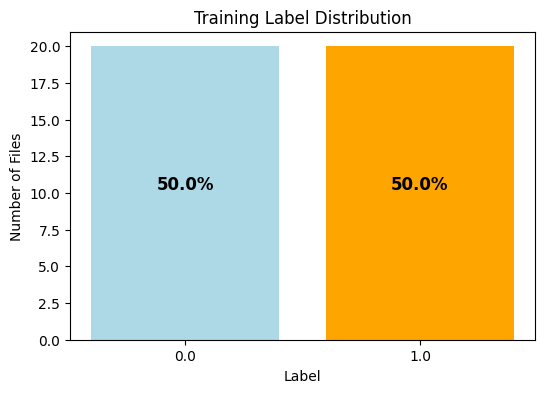

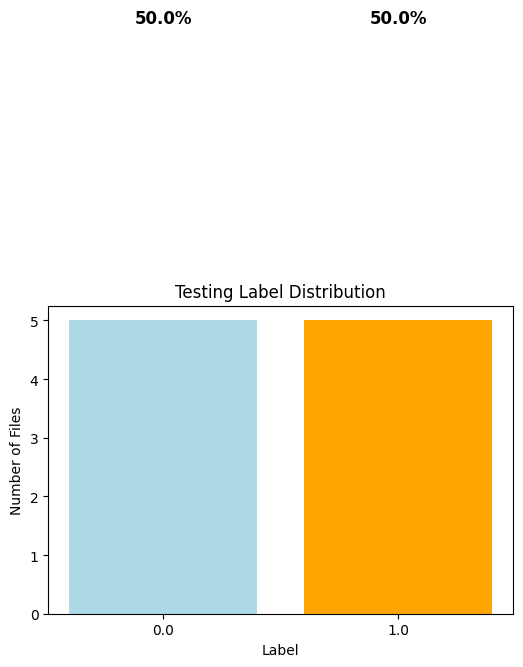

Skipped 0 files due to errors.
Skipped 0 files due to errors.

Training Data: 40 samples
Test Data: 10 samples

Sample training shapes:
lA0B2Fks6UMfTDPTAuyJXmZOHuo2.wav: (67072,)
e7JBCb0T95RkRfQCew31KafL19w1.wav: (66048,)
nsmJcSu7zRYegSynfe707MwRpjp2.wav: (15360,)
tkr2LeHuJyNXW3uM4NUZBmp1qIb2.wav: (32768,)
W42AKc6SZlNz1NOBAJrCpa3Io0E2.wav: (34816,)

Sample test shapes:
y6VWQQ5bW0drHBBQ74CmfwHniKo2.wav: (68608,)
RWVBQjQlHLbBjLazMN8hV2qZVx83.wav: (69632,)
j8snVeVNX8arLjDPnD9NGjL7MLD3.wav: (57856,)
31euepHD0deCxTd2nJ1wzXCk5EF3.wav: (17920,)
BPQxhBSlypXZICqfsmZcUYBxFmz1.wav: (32768,)


In [8]:
from step6_check_dataset import run_check_pipeline

# --- Paths ---
train_csv_path = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_train_labels_coswara.csv"
test_csv_path = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_test_labels_coswara.csv"

train_folder = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_train"
test_folder = "/content/drive/MyDrive/AML/Dataprep/test_coswara_dataprep_for_github/fortest_coswara_test"

# --- Run dataset check ---
run_check_pipeline(
    train_dir=train_folder,
    test_dir=test_folder,
    train_labels_path=train_csv_path,
    test_labels_path=test_csv_path
)

Expected Output:
- Console summary:
    - Total number of train and test .wav files found
    - Sample filenames printed from both sets
    - Detected ID column (e.g., filename)
    - Sample label pairs printed (filename + health_status)
    - Confirmed that file counts match label counts (e.g., 40 train files, 10 test files)
- Visual Output:
    - Bar chart for Training Label Distribution: Shows number and percentage for each class (e.g., 50% healthy, 50% not healthy)
    - Bar chart for Testing Label Distribution: Ensures balanced stratification across the test set
- Data loading:
    - Verifies that all .wav files can be loaded correctly using librosa
    - Displays sample audio shapes for 5 training and 5 test files
- Final outcome:
    - Ensures that the processed Coswara dataset is clean, label-aligned, balanced, and ready for model training or evaluation